In [1]:
from operator import itemgetter

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx

from cml_utils import build_toh_adj_matrix, gen_random_graph
import numpy as np

In [2]:
def draw_graph(adj_list):
    G = nx.Graph()
    for i, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            G.add_edge(i, neighbor.item())
    
    plt.figure(figsize=(8, 8))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.show()

In [3]:
def do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length, key):
    num_nodes = adj_matrix.shape[0]
    nodes = jnp.arange(num_nodes)
    trajectories = []
    for i in range(num_walks):
        key, key1 = jax.random.split(key)
        trajectory = []
        curr_node = jax.random.choice(key1, nodes).item()
        for j in range(walk_length):
            key, key1 = jax.random.split(key)
            next_node = jax.random.choice(key, jnp.where(adj_matrix[curr_node] == 1)[0]).item()
            trajectory.append((curr_node, edge_indices[(curr_node, next_node)], next_node))
            curr_node = next_node
        trajectories.append(trajectory)
    return jnp.array(trajectories), key

In [109]:
seed = 1234
key = jax.random.PRNGKey(seed)
adj_matrix, edge_indices = gen_random_graph(key)
num_walks = 200
walk_length = 32
trajectories, key = do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length, key)
n_obs = adj_matrix.shape[0]
n_act = len(edge_indices)
emb_dim = 1000
Q_init_stddev = 1.0
V_init_stddev = 0.1
W_init_stddev = 0.1
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 5

In [59]:
key, key1, key2, key3 = jax.random.split(key, 4)

In [120]:
Q = jax.random.normal(key1, (emb_dim, n_obs)) * Q_init_stddev
V = jax.random.normal(key2, (emb_dim, n_act)) * V_init_stddev
W = jax.random.normal(key3, (n_act, emb_dim)) * W_init_stddev
Q1 = Q.copy()
Q2 = Q.copy()
V1 = V.copy()
V2 = V.copy()

In [118]:
num_trajectories = trajectories.shape[0]
mses1 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]
        
        cur_obs = np.zeros((Q1.shape[1], len(nodes)))
        for idx, node in enumerate(nodes):
            cur_obs[node, idx] = 1
        next_obs = np.zeros((Q1.shape[1], len(next_nodes)))
        for idx, node in enumerate(next_nodes):
            next_obs[node, idx] = 1
        actions = np.zeros((V1.shape[1], len(edges)))
        for idx, edge in enumerate(edges):
            actions[edge, idx] = 1
        cur_obs = jnp.array(cur_obs)
        next_obs = jnp.array(next_obs)
        actions = jnp.array(actions)
        
        s_curr_DxL = Q1@cur_obs
        s_next_DxL = Q1@next_obs

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V1@actions

        V1 = eta_v * pred_err_DxL@actions.T
        Q1 = eta_q * pred_err_DxL@(cur_obs).T
        mses1.append((pred_err_DxL ** 2).mean())
        
    

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


In [113]:
num_trajectories = trajectories.shape[0]
mses2 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]

        s_curr_DxL = Q[:, nodes]
        s_next_DxL = Q[:, next_nodes]

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V[:, edges]

        V = V.at[:, edges].add(eta_v * pred_err_DxL)
        Q = Q.at[:, next_nodes].add(- eta_q * pred_err_DxL)
        W = W.at[edges, :].add(eta_w * s_diff_DxL.T)
        mses2.append((pred_err_DxL ** 2).mean())
Q2 = Q.copy()

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


In [92]:
jnp.abs(Q1-Q2).max()

Array(1.7404578, dtype=float32)

In [116]:
mses1

[Array(2.0227294, dtype=float32),
 Array(0.22698829, dtype=float32),
 Array(0.02305915, dtype=float32),
 Array(0.00072436, dtype=float32),
 Array(1.3266846e-06, dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dt

In [117]:
mses2

[Array(2.022736, dtype=float32),
 Array(1.3271995, dtype=float32),
 Array(1.0153074, dtype=float32),
 Array(1.6694015, dtype=float32),
 Array(0.9724534, dtype=float32),
 Array(0.51815504, dtype=float32),
 Array(0.6188098, dtype=float32),
 Array(0.4732336, dtype=float32),
 Array(0.3147994, dtype=float32),
 Array(0.17161058, dtype=float32),
 Array(0.16479878, dtype=float32),
 Array(0.12343157, dtype=float32),
 Array(0.249209, dtype=float32),
 Array(0.18129313, dtype=float32),
 Array(0.1978769, dtype=float32),
 Array(0.17851551, dtype=float32),
 Array(0.18686567, dtype=float32),
 Array(0.05849643, dtype=float32),
 Array(0.1421823, dtype=float32),
 Array(0.10872545, dtype=float32),
 Array(0.05279535, dtype=float32),
 Array(0.16942714, dtype=float32),
 Array(0.07703229, dtype=float32),
 Array(0.06980792, dtype=float32),
 Array(0.06375578, dtype=float32),
 Array(0.04313683, dtype=float32),
 Array(0.05448576, dtype=float32),
 Array(0.04257365, dtype=float32),
 Array(0.05351235, dtype=float32)

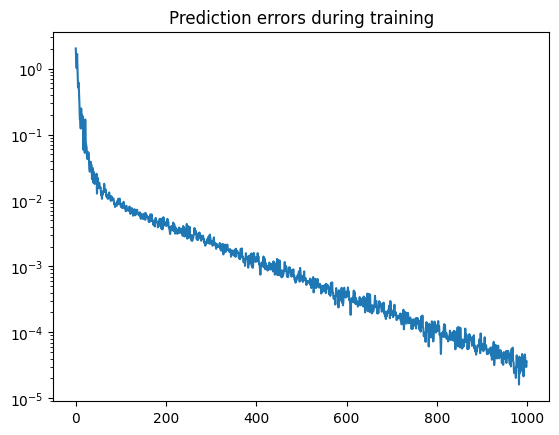

In [115]:
fig, ax = plt.subplots()
ax.plot(mses2)
ax.set_title('Prediction errors during training')
ax.set_yscale('log')
plt.show()
plt.close(fig)

In [42]:
import gymnasium as gym
import gymnasium_robotics

gym.register_envs(gymnasium_robotics)

env = gym.make("FetchReach-v2")
# print(env.reset())
print(env.action_space.sample())
print(env.observation_space.sample())

[ 0.5092071  -0.87236583 -0.0854843  -0.32983938]
OrderedDict([('achieved_goal', array([-0.87827752,  1.18349779,  0.75674453])), ('desired_goal', array([ 1.33397615,  0.71079041, -0.2907592 ])), ('observation', array([ 0.02876074,  0.74619192, -0.0678519 ,  0.48257909, -0.34181877,
       -0.85470401,  0.95182396,  0.03988686, -0.06033874,  1.18600247]))])


In [191]:
trajectories = []
episode_reward = 0
cur_obs, info = env.reset()
cur_obs = cur_obs["observation"][[0, 1, 2, 5, 6, 7]]

In [195]:
def discrete_action(action):
    action = ((action[:-1])*50+0.5)
    idx = action[0] + action[1]*2+action[2]*4
    return np.eye(8)[:, int(idx)]

In [197]:
while len(trajectories) < 10000:
    action = env.action_space.sample()
    action = np.where(action < 0, -0.01, 0.01)
    obs, reward, terminated, truncated, info = env.step(action)
    obs = obs["observation"][[0, 1, 2, 5, 6, 7]]
    lb = cur_obs - np.array([0.5, 0, 0.1, -0.03, -0.03, -0.03])
    ub = cur_obs - np.array([1.5, 1.5, 1.1, 0.03, 0.03, 0.03])
    if np.all(lb > 0) and np.all(ub < 0):
        action = discrete_action(action)
        trajectories.append(np.concatenate([cur_obs, action, obs]))
    cur_obs = obs
    # print(episode_reward) 
    # if terminated or truncated or info.get("is_success", False):
    #     print("Reward:", episode_reward, "Success?", info.get("is_success", False))
    #     episode_reward = 0.0
    #     obs, info = env.reset()

In [198]:
action

array([0., 0., 0., 0., 0., 0., 0., 1.])

In [199]:
trajs_np = np.array(trajectories)

In [200]:
trajs_np[:10, 6:6+8]

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: ylabel='Count'>

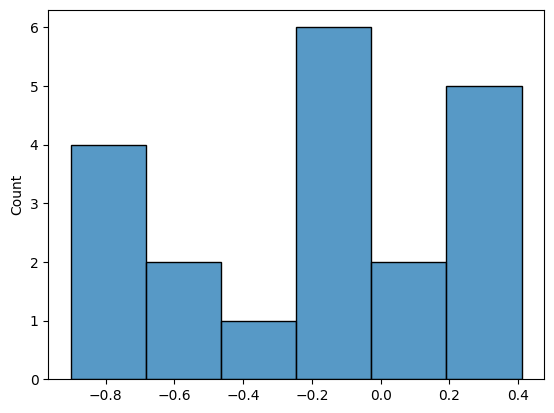

In [101]:
sns.histplot(trajs_np[:, 6])

In [114]:
def obs_continuous_to_bin(obs_con, p=0.01):
    """
    obs_con[0] in [0.5, 1.5],
    obs_con[1] in [0, 1.5],
    obs_con[2] in [0.1, 1.1],
    obs_con[3:6] in [-0.03, 0.03]
    """
    delta_bins = np.array([0, 1 // p, 1.5 // p, 1 // p, 0.06 // p, 0.06 // p])
    obs_discrete = obs_con.copy()
    lb = np.array([0.5, 0, 0.1, -0.03, -0.03, -0.03])
    obs_discrete -= lb
    obs_discrete //= p
    # obs_discrete[:, 0] = (obs_discrete[:, 0] - 0.5) // p
    # obs_discrete[:, 1] = (obs_discrete[:, 1] - 0) // p
    # obs_discrete[:, 2] = (obs_discrete[:, 2] - 0.1) // p
    # obs_discrete[:, 3] = (obs_discrete[:, 3] + 0.03) // p
    # obs_discrete[:, 4] = (obs_discrete[:, 4] + 0.03) // p
    # obs_discrete[:, 5] = (obs_discrete[:, 5] + 0.03) // p
    obs_discrete += delta_bins
    obs_discrete = np.sum(obs_discrete, axis=1, dtype=np.int32)
    return obs_discrete

In [204]:
trajs_jnp = jnp.array(trajectories)

In [123]:
key, key1, key2, key3 = jax.random.split(key, 4)

In [228]:
emb_dim = 4000
n_obs = 6
n_act = 8
Q_init_stddev = 1.0
V_init_stddev = 0.1
W_init_stddev = 0.1
eta_q = 0.025
eta_v = 0.005
eta_w = 0.005

In [234]:
Q = jax.random.normal(key1, (emb_dim, n_obs)) * Q_init_stddev
V = jax.random.normal(key2, (emb_dim, n_act)) * V_init_stddev
W = jax.random.normal(key3, (n_act, emb_dim)) * W_init_stddev

In [235]:
mses = []
for epoch in range(10):
    s_curr_DxL = Q @ trajs_jnp[:, :6].T
    s_next_DxL = Q @ trajs_jnp[:, 14:].T
    s_diff_DxL = s_next_DxL - V @ trajs_jnp[:, 6:14].T
    V += eta_v * s_diff_DxL @ trajs_jnp[:, 6:14]
    # V = V.at[:, edges].add(eta_v * pred_err_DxL)
    Q += eta_q * s_diff_DxL @ (trajs_jnp[:, :6] - trajs_jnp[:, 14:])
    # W += eta_w * (s_diff_DxL @ trajs_jnp[:, 6:14]).T
    # pred_err_DxL = s_diff_DxL - V @ trajs_jnp[:, 6:14].T
    mses.append((s_diff_DxL ** 2).mean())

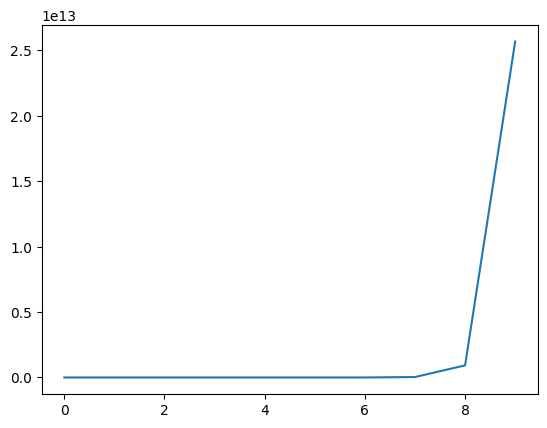

In [236]:
plt.plot(mses)

In [133]:
trajs_jnp[:, :6].shape

(10000, 6)

In [135]:
Q.shape

(1000, 6)

In [136]:
s_curr_DxL = Q @ trajs_jnp[:, :6].T

In [137]:
s_next_DxL = Q @ trajs_jnp[:, 9:].T

In [138]:
s_diff_DxL = s_next_DxL - s_curr_DxL

In [139]:
s_diff_DxL.shape

(1000, 10000)

In [141]:
trajs_jnp[:, 6:9].shape

(10000, 3)

In [143]:
W

(3, 1000)

In [144]:
V.shape

(1000, 3)